In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

def load_and_inspect_data(filepath):
    """Load the dataset and perform initial inspection"""
    print("="*50)
    print("LOADING AND INITIAL INSPECTION")
    print("="*50)
    # Load data
    df = pd.read_csv(filepath, encoding='cp1252')
    
    # Basic info
    print(f"Dataset shape: {df.shape}")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("\nColumn names:")
    for i, col in enumerate(df.columns, 1):
        print(f"{i}. {col}")
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
    # First few rows
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Last few rows
    print("\nLast 5 rows:")
    print(df.tail())
    
    return df

def clean_and_preprocess_data(df):
    """Clean and preprocess the dataset"""
    print("\n" + "="*50)
    print("DATA CLEANING AND PREPROCESSING")
    print("="*50)
    
    df_clean = df.copy()
    
    # Check for missing values
    print("Missing values per column:")
    missing_vals = df_clean.isnull().sum()
    missing_percent = (missing_vals / len(df_clean)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_vals,
        'Missing Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # Check for duplicates
    duplicates = df_clean.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")
    
    # Clean numeric columns - extract numbers from strings
    def extract_numeric(series, column_name):
        """Extract numeric values from string columns"""
        print(f"\nCleaning {column_name}...")
        
        # Convert to string first to handle any NaN values
        series_str = series.astype(str)
        
        # Extract numeric values using regex
        numeric_series = series_str.str.extract(r'(\d+(?:\.\d+)?)', expand=False)
        numeric_series = pd.to_numeric(numeric_series, errors='coerce')
        
        print(f"Successfully extracted {numeric_series.notna().sum()} numeric values")
        print(f"Failed to extract {numeric_series.isna().sum()} values")
        
        return numeric_series
    
    # Clean numeric columns
    if 'CC/Battery Capacity' in df_clean.columns:
        df_clean['CC_Numeric'] = extract_numeric(df_clean['CC/Battery Capacity'], 'CC/Battery Capacity')
    
    if 'HorsePower' in df_clean.columns:
        df_clean['HP_Numeric'] = extract_numeric(df_clean['HorsePower'], 'HorsePower')
    
    if 'Total Speed' in df_clean.columns:
        df_clean['TopSpeed_Numeric'] = extract_numeric(df_clean['Total Speed'], 'Total Speed')
    
    if 'Performance(0 - 100 )KM/H' in df_clean.columns:
        df_clean['Acceleration_Numeric'] = extract_numeric(df_clean['Performance(0 - 100 )KM/H'], 'Acceleration')
    
    if 'Cars Prices' in df_clean.columns:
        df_clean['Price_Numeric'] = extract_numeric(df_clean['Cars Prices'], 'Price')
    
    if 'Seats' in df_clean.columns:
        df_clean['Seats_Numeric'] = extract_numeric(df_clean['Seats'], 'Seats')
    
    if 'Torque' in df_clean.columns:
        df_clean['Torque_Numeric'] = extract_numeric(df_clean['Torque'], 'Torque')
    
    return df_clean

def analyze_categorical_data(df):
    """Analyze categorical columns"""
    print("\n" + "="*50)
    print("CATEGORICAL DATA ANALYSIS")
    print("="*50)
    
    categorical_cols = ['Company Names', 'Cars Names', 'Engines', 'Fuel Types']
    
    for col in categorical_cols:
        if col in df.columns:
            print(f"\n--- {col} ---")
            value_counts = df[col].value_counts()
            print(f"Number of unique values: {df[col].nunique()}")
            print(f"Top 10 most frequent values:")
            print(value_counts.head(10))
            
            # Plot top categories
            plt.figure(figsize=(12, 6))
            if len(value_counts) > 20:
                top_values = value_counts.head(15)
                plt.title(f'Top 15 {col}')
            else:
                top_values = value_counts
                plt.title(f'{col} Distribution')
            
            top_values.plot(kind='bar')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

def analyze_numerical_data(df):
    """Analyze numerical columns"""
    print("\n" + "="*50)
    print("NUMERICAL DATA ANALYSIS")
    print("="*50)
    
    numeric_cols = ['CC_Numeric', 'HP_Numeric', 'TopSpeed_Numeric', 
                   'Acceleration_Numeric', 'Price_Numeric', 'Seats_Numeric', 'Torque_Numeric']
    
    available_numeric_cols = [col for col in numeric_cols if col in df.columns and df[col].notna().sum() > 0]
    
    if not available_numeric_cols:
        print("No numeric columns available for analysis")
        return
    
    # Descriptive statistics
    print("Descriptive Statistics:")
    numeric_df = df[available_numeric_cols]
    print(numeric_df.describe())
    
    # Distribution plots
    n_cols = len(available_numeric_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(available_numeric_cols):
        if i < len(axes):
            df[col].hist(bins=30, ax=axes[i], alpha=0.7)
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    # Hide empty subplots
    for i in range(len(available_numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Box plots for outlier detection
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(available_numeric_cols):
        if i < len(axes):
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(f'Box Plot of {col}')
    
    # Hide empty subplots
    for i in range(len(available_numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return available_numeric_cols

def correlation_analysis(df, numeric_cols):
    """Perform correlation analysis"""
    print("\n" + "="*50)
    print("CORRELATION ANALYSIS")
    print("="*50)
    
    if len(numeric_cols) < 2:
        print("Need at least 2 numeric columns for correlation analysis")
        return
    
    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()
    print("Correlation Matrix:")
    print(corr_matrix)
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                vmin=-1, vmax=1, center=0, square=True, linewidths=0.5)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Find strong correlations
    print("\nStrong correlations (|r| > 0.5):")
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                print(f"{corr_matrix.columns[i]} vs {corr_matrix.columns[j]}: {corr_val:.3f}")

def analyze_by_fuel_type(df, numeric_cols):
    """Analyze data by fuel type"""
    print("\n" + "="*50)
    print("ANALYSIS BY FUEL TYPE")
    print("="*50)
    
    if 'Fuel Types' not in df.columns:
        print("Fuel Types column not available")
        return
    
    # Group by fuel type
    fuel_groups = df.groupby('Fuel Types')
    
    print("Statistics by Fuel Type:")
    for col in numeric_cols:
        if df[col].notna().sum() > 0:
            print(f"\n--- {col} by Fuel Type ---")
            fuel_stats = fuel_groups[col].agg(['count', 'mean', 'median', 'std'])
            print(fuel_stats)
            
            # Box plot by fuel type
            plt.figure(figsize=(10, 6))
            df.boxplot(column=col, by='Fuel Types', figsize=(12, 6))
            plt.title(f'{col} by Fuel Type')
            plt.suptitle('')  # Remove default title
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

def analyze_by_company(df, numeric_cols):
    """Analyze data by company"""
    print("\n" + "="*50)
    print("ANALYSIS BY COMPANY (TOP 10)")
    print("="*50)
    
    if 'Company Names' not in df.columns:
        print("Company Names column not available")
        return
    
    # Get top 10 companies by count
    top_companies = df['Company Names'].value_counts().head(10).index
    df_top_companies = df[df['Company Names'].isin(top_companies)]
    
    print("Top 10 companies by number of models:")
    print(df['Company Names'].value_counts().head(10))
    
    # Analysis by company
    for col in numeric_cols:
        if df[col].notna().sum() > 0:
            print(f"\n--- {col} by Company (Top 10) ---")
            company_stats = df_top_companies.groupby('Company Names')[col].agg(['count', 'mean', 'median', 'std'])
            print(company_stats.sort_values('mean', ascending=False))
            
            # Box plot by company
            plt.figure(figsize=(14, 6))
            df_top_companies.boxplot(column=col, by='Company Names', figsize=(14, 6))
            plt.title(f'{col} by Company (Top 10)')
            plt.suptitle('')  # Remove default title
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

def detect_outliers(df, numeric_cols):
    """Detect outliers using IQR method"""
    print("\n" + "="*50)
    print("OUTLIER DETECTION")
    print("="*50)
    
    for col in numeric_cols:
        if df[col].notna().sum() > 0:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            
            print(f"\n--- {col} ---")
            print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
            print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
            print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
            
            if len(outliers) > 0 and len(outliers) <= 10:
                print("Outlier details:")
                print(outliers[['Company Names', 'Cars Names', col]].to_string())

def main_analysis(filepath):
    """Run complete EDA analysis"""
    print("CARS DATASET - EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    # Load and inspect data
    df = load_and_inspect_data(filepath)
    
    # Clean and preprocess
    df_clean = clean_and_preprocess_data(df)
    
    # Categorical analysis
    analyze_categorical_data(df_clean)
    
    # Numerical analysis
    numeric_cols = analyze_numerical_data(df_clean)
    
    # Correlation analysis
    if numeric_cols and len(numeric_cols) > 1:
        correlation_analysis(df_clean, numeric_cols)
    
    # Analysis by fuel type
    analyze_by_fuel_type(df_clean, numeric_cols)
    
    # Analysis by company
    analyze_by_company(df_clean, numeric_cols)
    
    # Outlier detection
    detect_outliers(df_clean, numeric_cols)
    
    print("\n" + "="*60)
    print("EDA ANALYSIS COMPLETE!")
    print("="*60)
    
    return df_clean



CARS DATASET - EXPLORATORY DATA ANALYSIS
LOADING AND INITIAL INSPECTION
Dataset shape: (1218, 11)
Number of rows: 1218
Number of columns: 11

Column names:
1. Company Names
2. Cars Names
3. Engines
4. CC/Battery Capacity
5. HorsePower
6. Total Speed
7. Performance(0 - 100 )KM/H
8. Cars Prices
9. Fuel Types
10. Seats
11. Torque

Data types:
Company Names                object
Cars Names                   object
Engines                      object
CC/Battery Capacity          object
HorsePower                   object
Total Speed                  object
Performance(0 - 100 )KM/H    object
Cars Prices                  object
Fuel Types                   object
Seats                        object
Torque                       object
dtype: object

First 5 rows:
  Company Names     Cars Names      Engines CC/Battery Capacity HorsePower  \
0       FERRARI  SF90 STRADALE           V8             3990 cc     963 hp   
1   ROLLS ROYCE        PHANTOM          V12             6749 cc     563 hp   

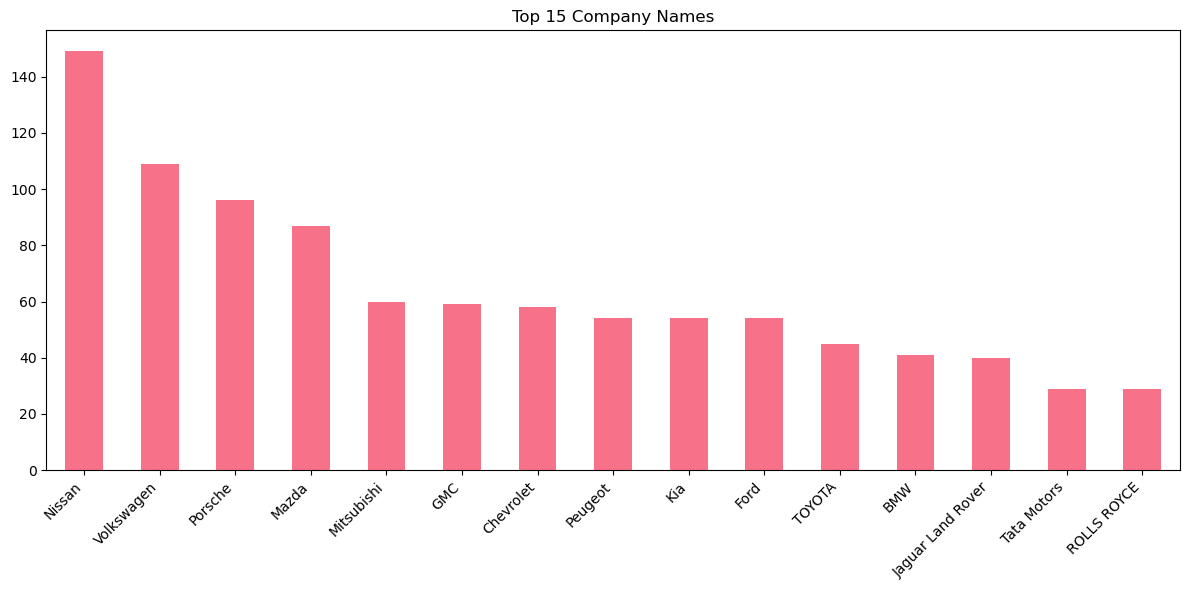


--- Cars Names ---
Number of unique values: 1201
Top 10 most frequent values:
Macan T           2
Tiago EV          2
911 Carrera 4     2
Tahoe RST         2
200SX             2
Macan GTS         2
Macan S           2
MIRAI             2
Malibu Premier    2
Mistral           2
Name: Cars Names, dtype: int64


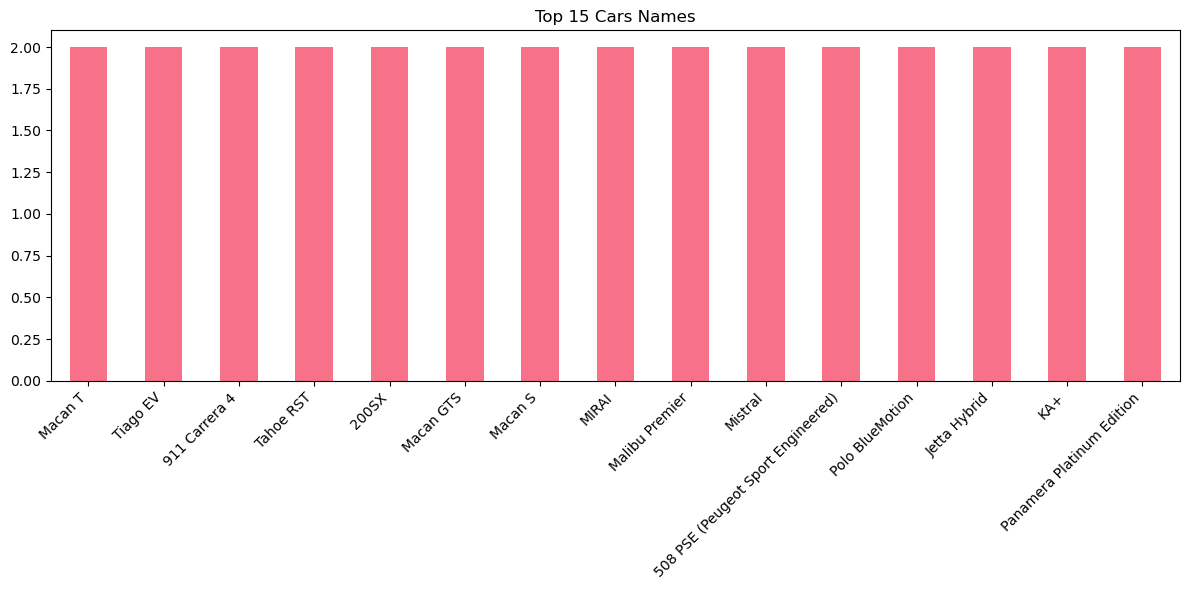


--- Engines ---
Number of unique values: 356
Top 10 most frequent values:
I4                      64
V12                     51
V6                      39
Inline-4                38
V8                      34
Dual Electric Motors    23
Electric Motor          20
2.0L Inline-4           20
1.6L Inline-4           19
5.6L V8                 17
Name: Engines, dtype: int64


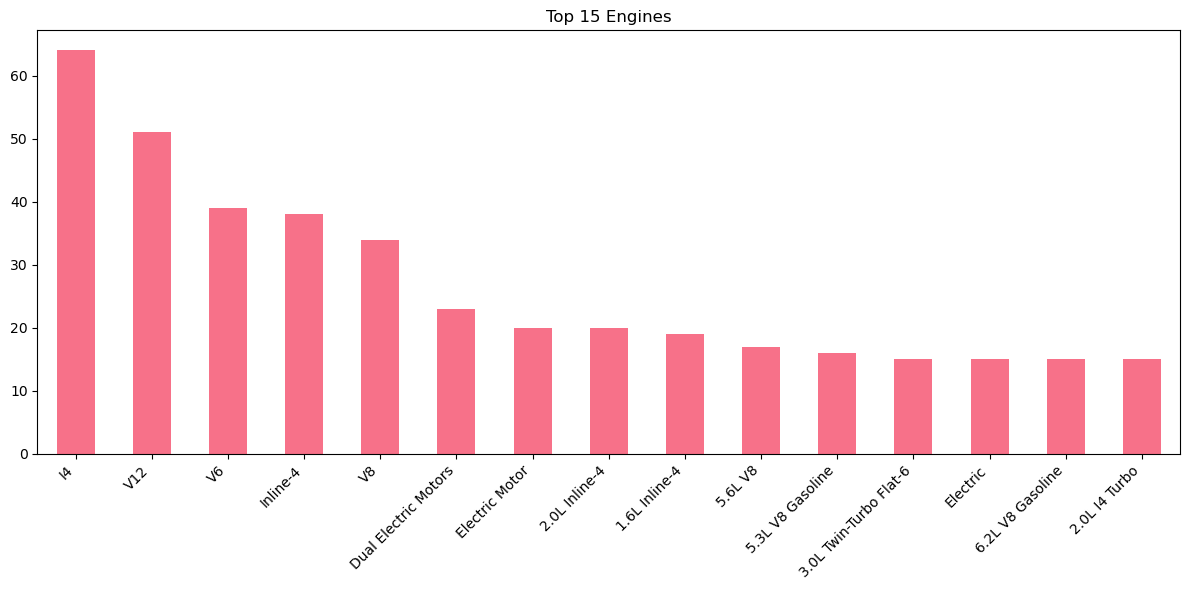


--- Fuel Types ---
Number of unique values: 23
Top 10 most frequent values:
Petrol             871
Diesel             106
Electric            97
Hybrid              79
Petrol/Diesel       16
Petrol/Hybrid       16
Plug-in Hybrid       5
Diesel/Petrol        4
Hybrid (Petrol)      4
Hydrogen             3
Name: Fuel Types, dtype: int64


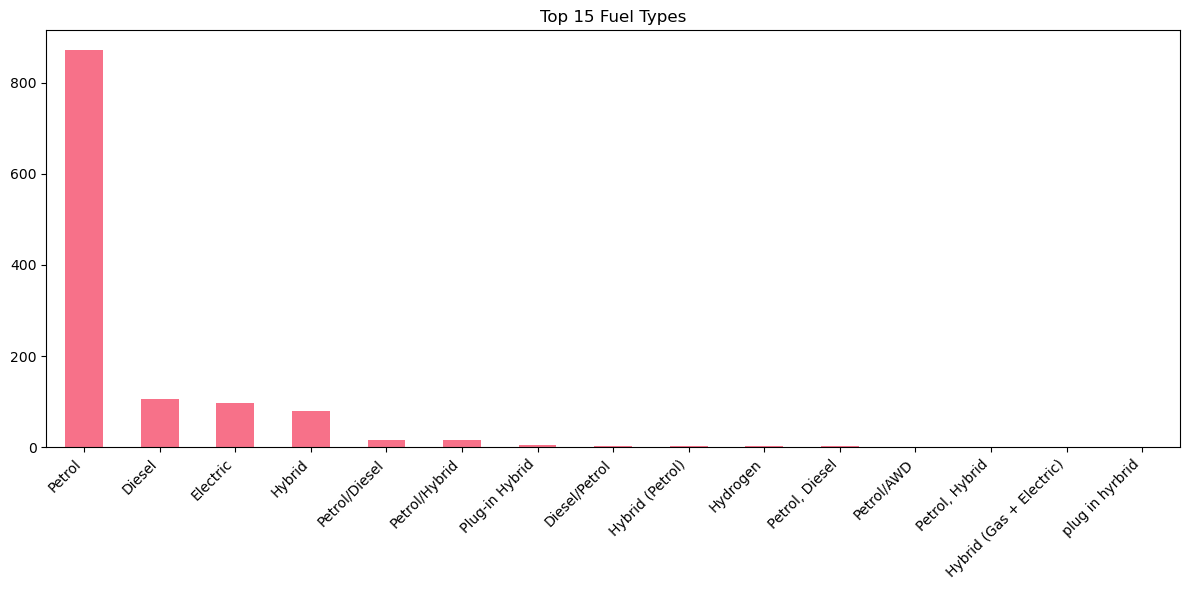


NUMERICAL DATA ANALYSIS
Descriptive Statistics:
         CC_Numeric   HP_Numeric  TopSpeed_Numeric  Acceleration_Numeric  \
count   1213.000000  1218.000000       1218.000000           1212.000000   
mean    1413.553009   300.397373        216.467159              7.563614   
std     2023.302367   219.343342         53.051077              3.310014   
min        1.000000     1.000000         80.000000              1.900000   
25%        2.000000   150.000000        180.000000              5.200000   
50%       82.000000   250.000000        200.000000              7.100000   
75%     2000.000000   400.000000        250.000000              9.500000   
max    16100.000000  2488.000000        500.000000             35.000000   

       Price_Numeric  Seats_Numeric  Torque_Numeric  
count    1217.000000    1218.000000     1217.000000  
mean       68.829088       4.833333      425.949877  
std        88.834719       1.521462      290.616325  
min         1.000000       1.000000        1.00000

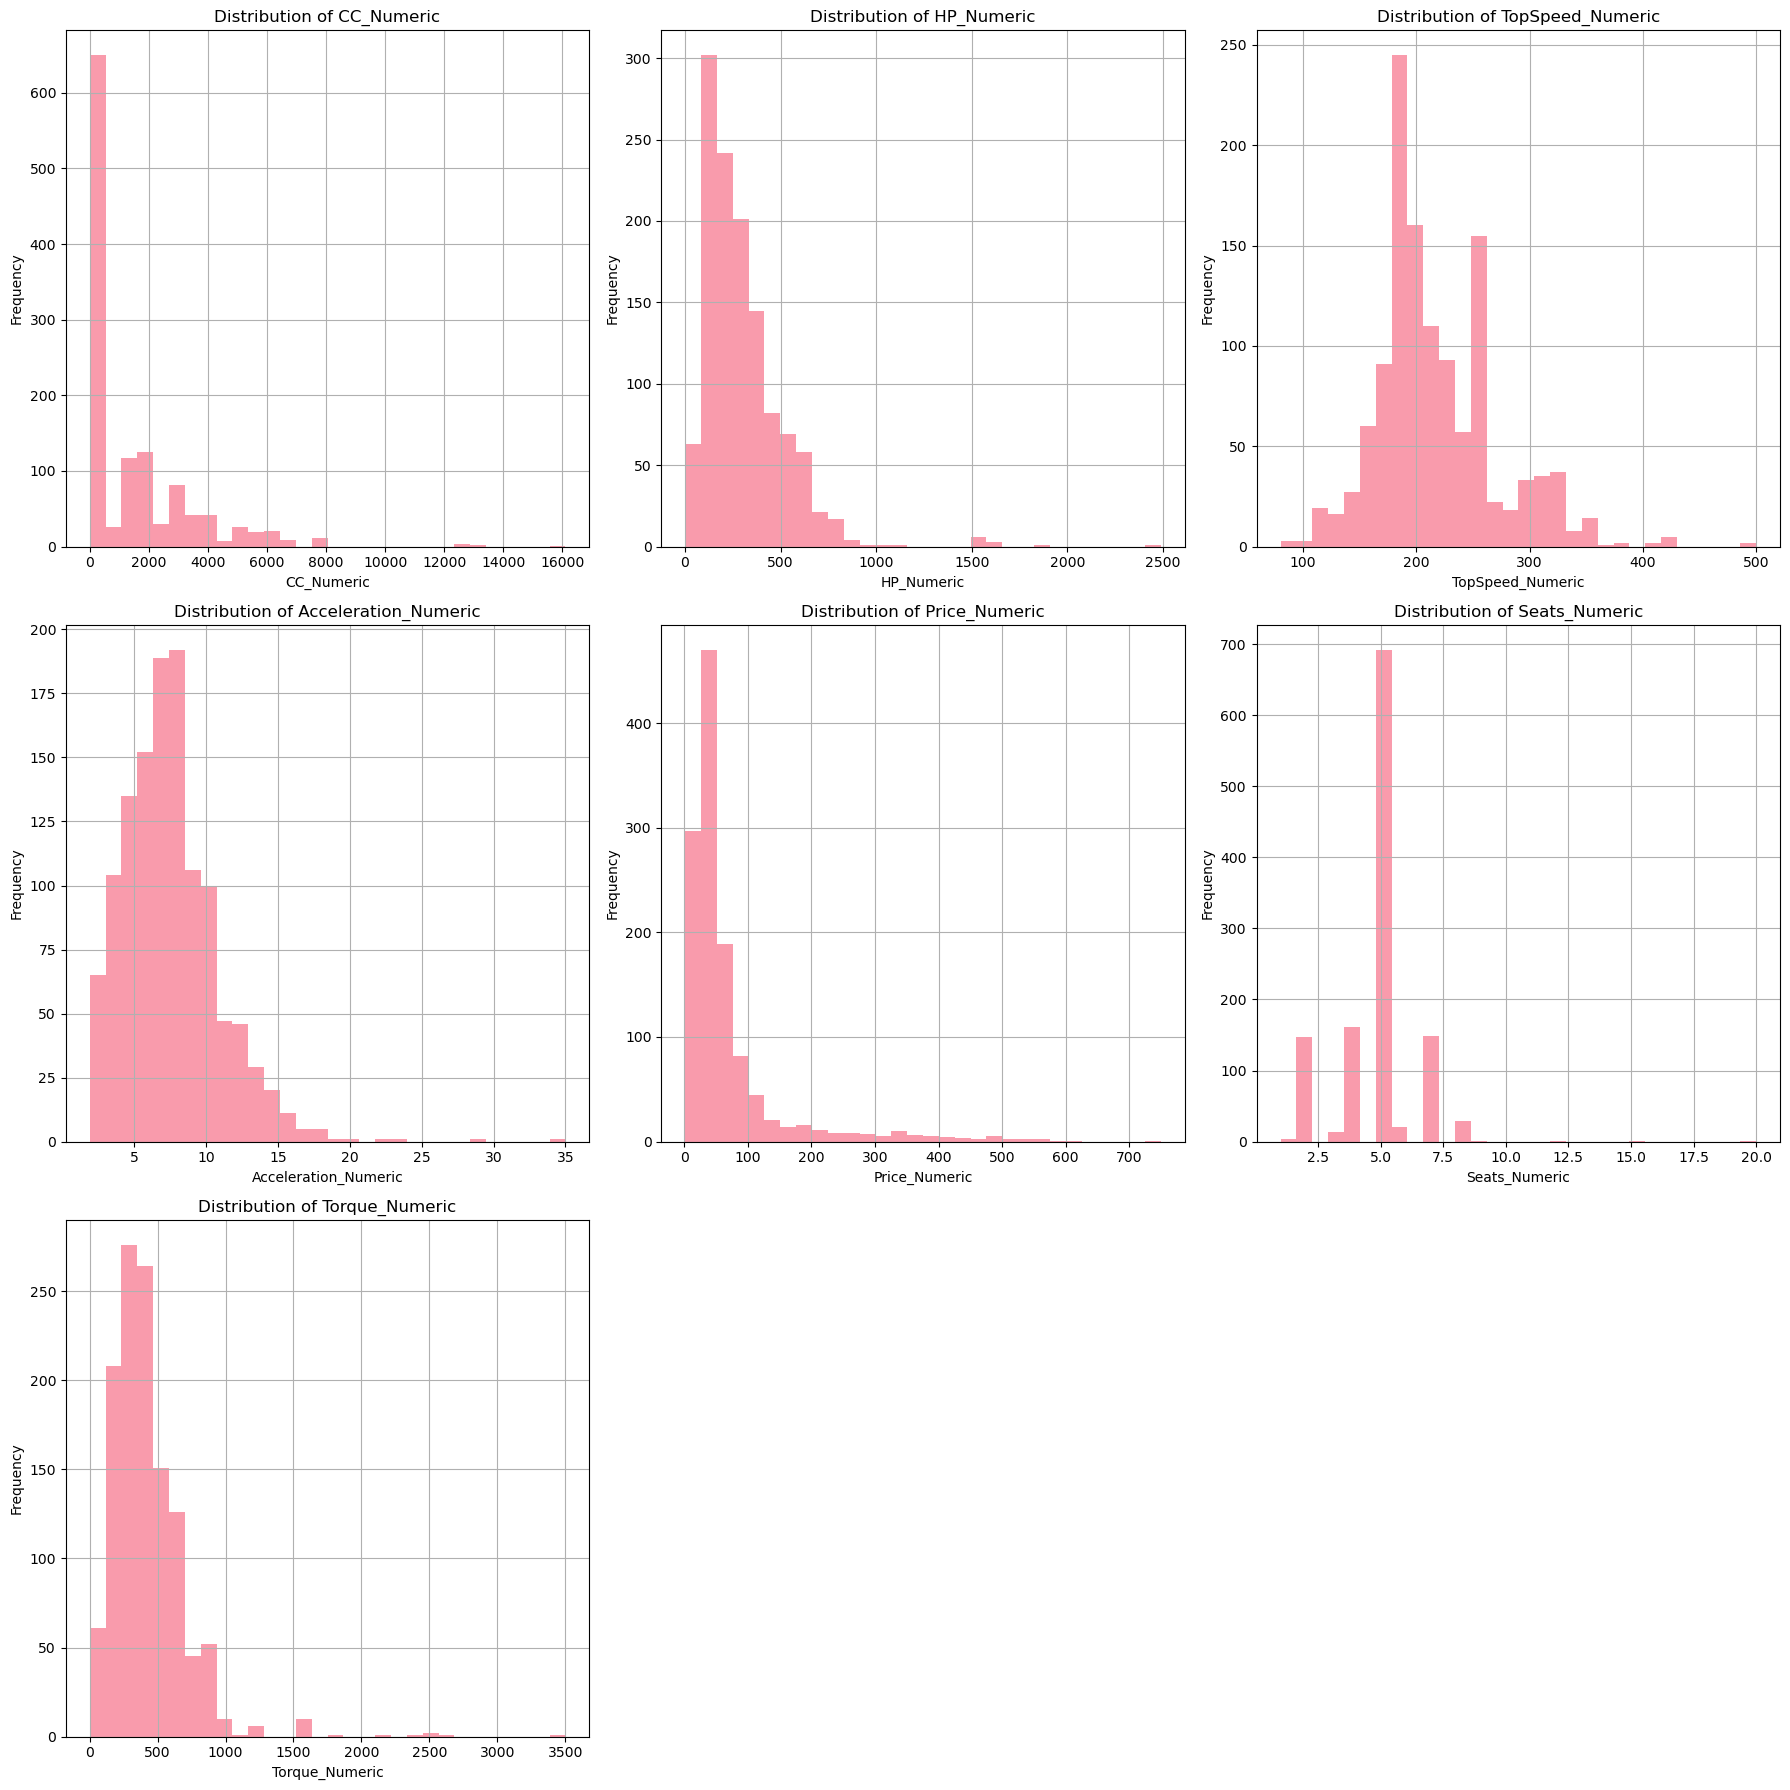

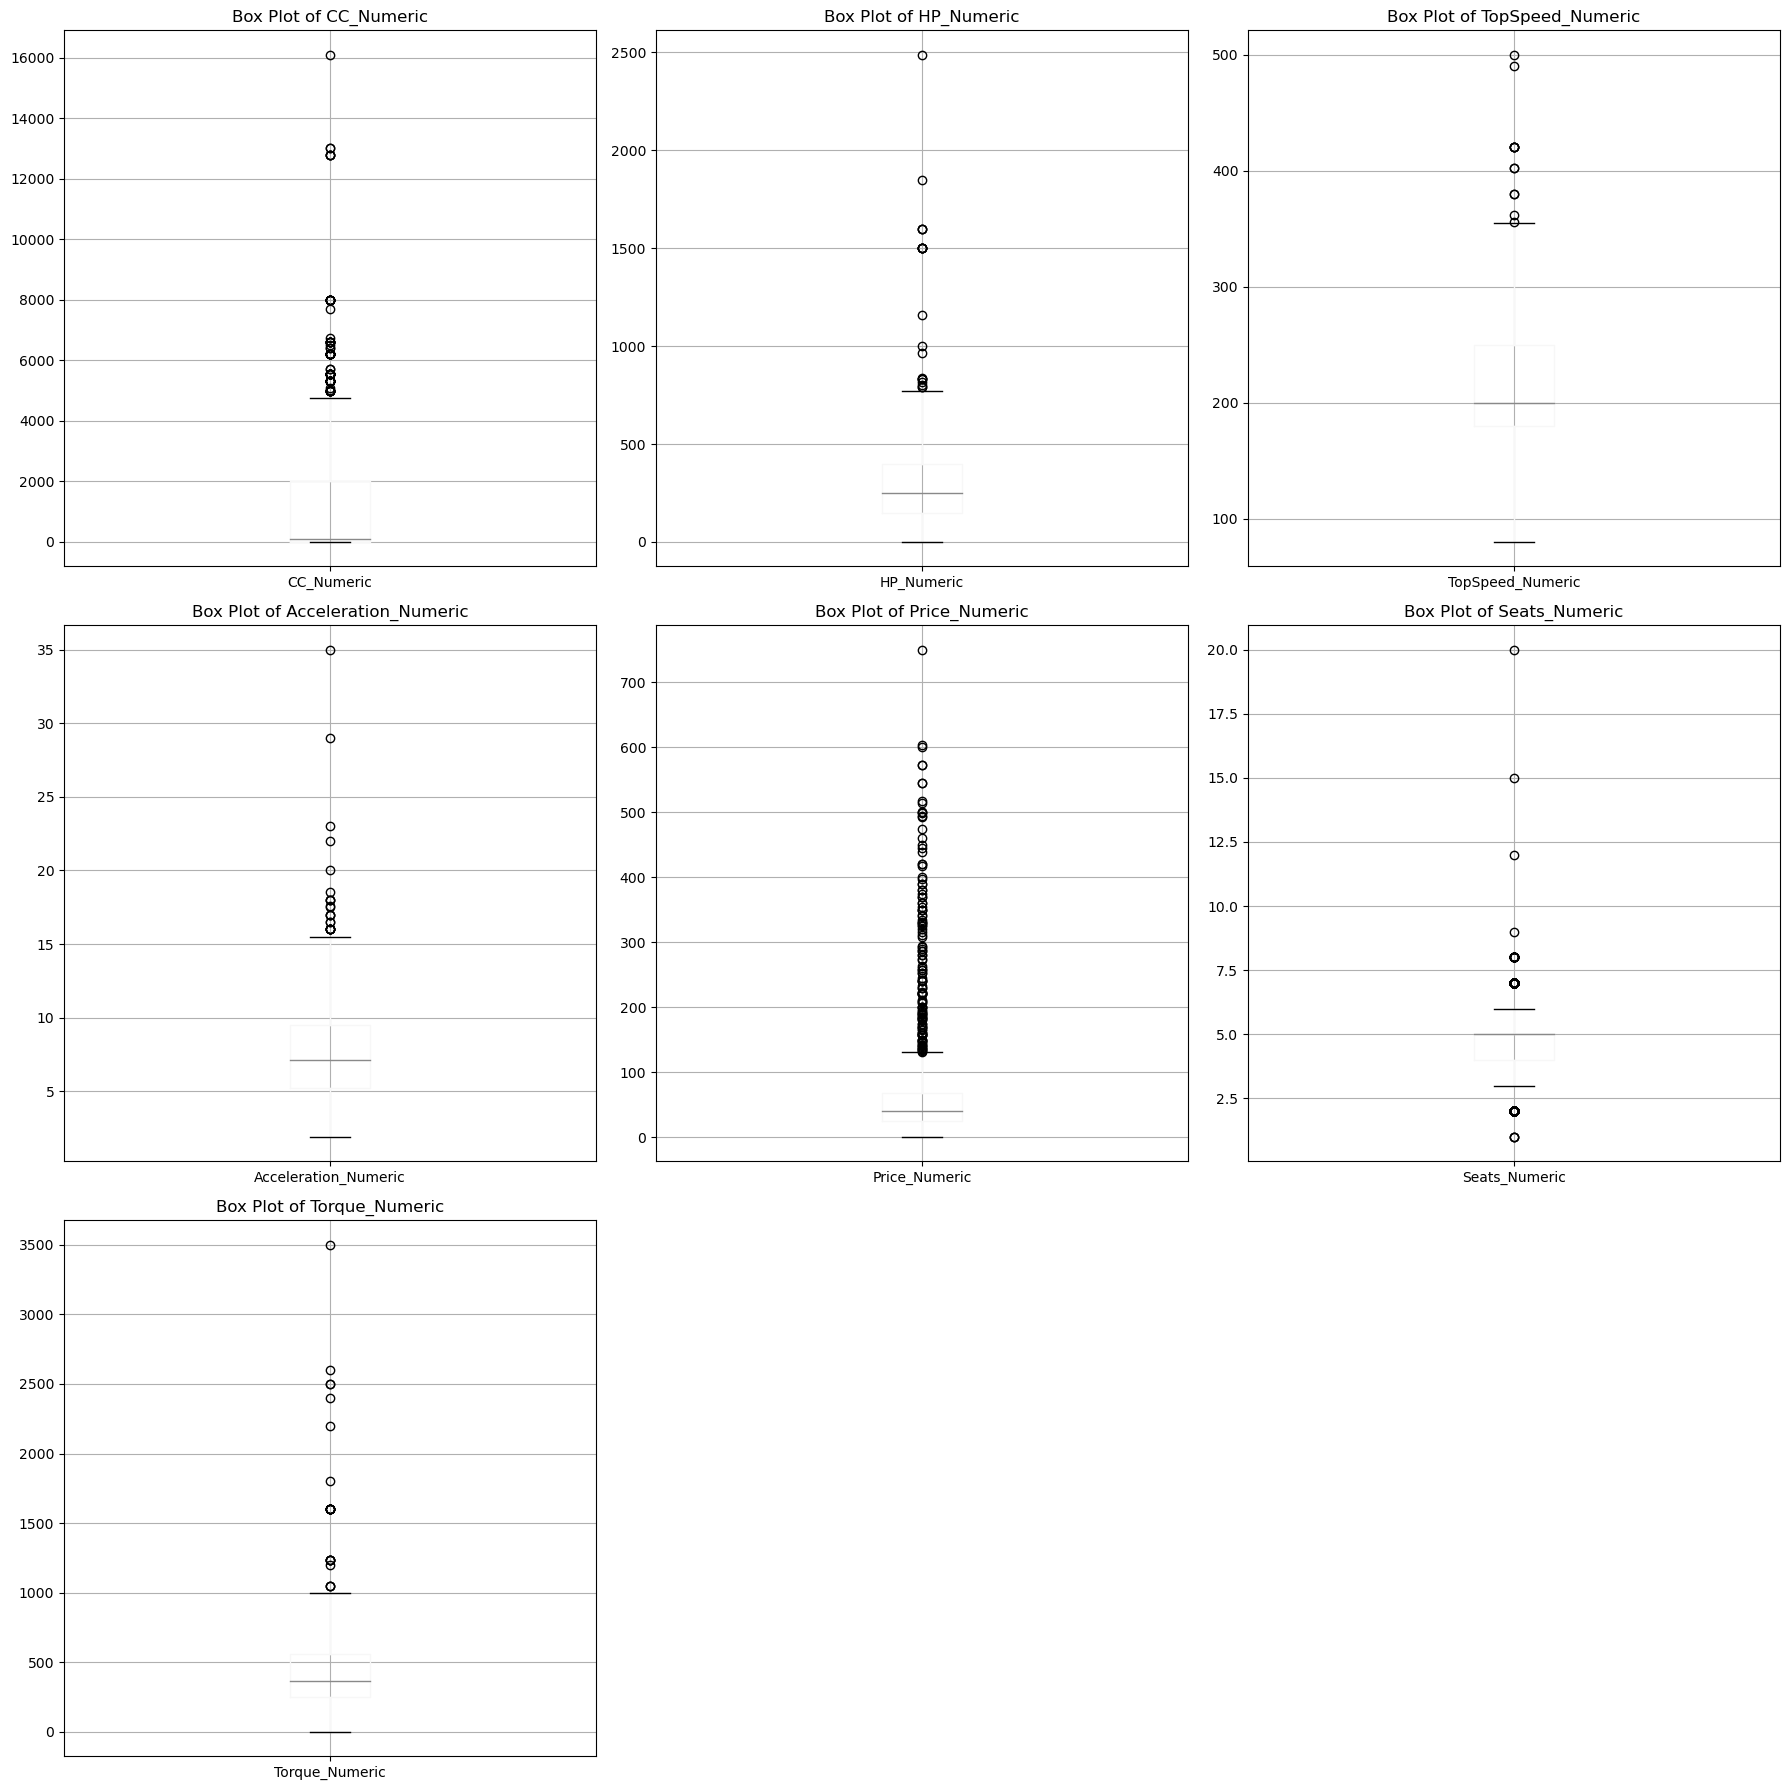


CORRELATION ANALYSIS
Correlation Matrix:
                      CC_Numeric  HP_Numeric  TopSpeed_Numeric  \
CC_Numeric              1.000000    0.325302          0.129995   
HP_Numeric              0.325302    1.000000          0.695005   
TopSpeed_Numeric        0.129995    0.695005          1.000000   
Acceleration_Numeric   -0.040117   -0.619853         -0.784731   
Price_Numeric           0.017460    0.499518          0.500044   
Seats_Numeric          -0.033620   -0.242479         -0.385941   
Torque_Numeric          0.501184    0.731909          0.436314   

                      Acceleration_Numeric  Price_Numeric  Seats_Numeric  \
CC_Numeric                       -0.040117       0.017460      -0.033620   
HP_Numeric                       -0.619853       0.499518      -0.242479   
TopSpeed_Numeric                 -0.784731       0.500044      -0.385941   
Acceleration_Numeric              1.000000      -0.450574       0.188418   
Price_Numeric                    -0.450574       

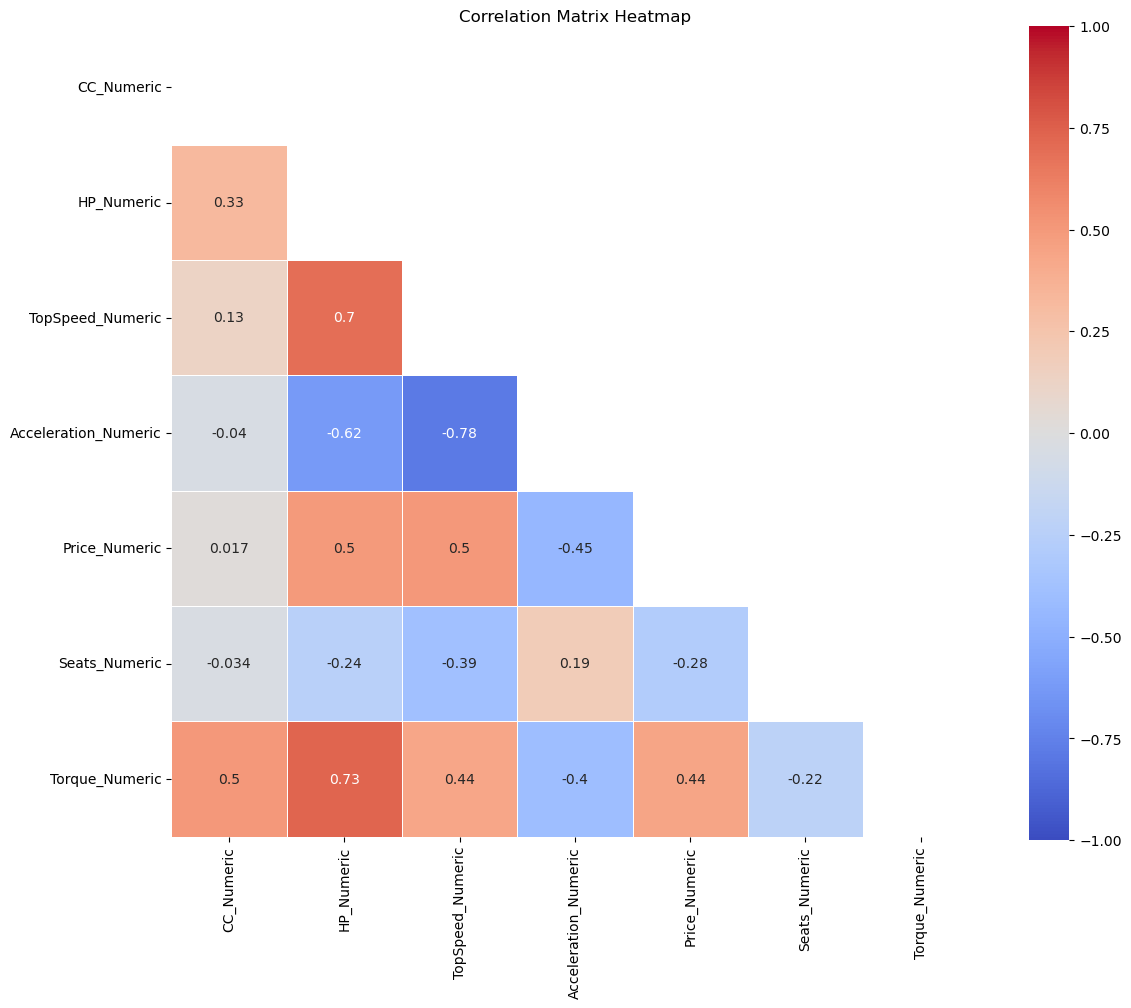


Strong correlations (|r| > 0.5):
CC_Numeric vs Torque_Numeric: 0.501
HP_Numeric vs TopSpeed_Numeric: 0.695
HP_Numeric vs Acceleration_Numeric: -0.620
HP_Numeric vs Torque_Numeric: 0.732
TopSpeed_Numeric vs Acceleration_Numeric: -0.785
TopSpeed_Numeric vs Price_Numeric: 0.500

ANALYSIS BY FUEL TYPE
Statistics by Fuel Type:

--- CC_Numeric by Fuel Type ---
                         count         mean   median          std
Fuel Types                                                       
CNG/Petrol                   1  1199.000000  1199.00          NaN
Diesel                     105  2257.619048  1390.00  3517.145648
Diesel Hybrid                1     3.000000     3.00          NaN
Diesel/Petrol                4   973.500000  1248.00   651.413591
Electric                    94    87.692553    79.20    44.911577
Gas / Hybrid                 1  1987.000000  1987.00          NaN
Hybrid                      79   891.088608    11.40  1153.242143
Hybrid (Gas + Electric)      1  2487.000000  248

<Figure size 1000x600 with 0 Axes>

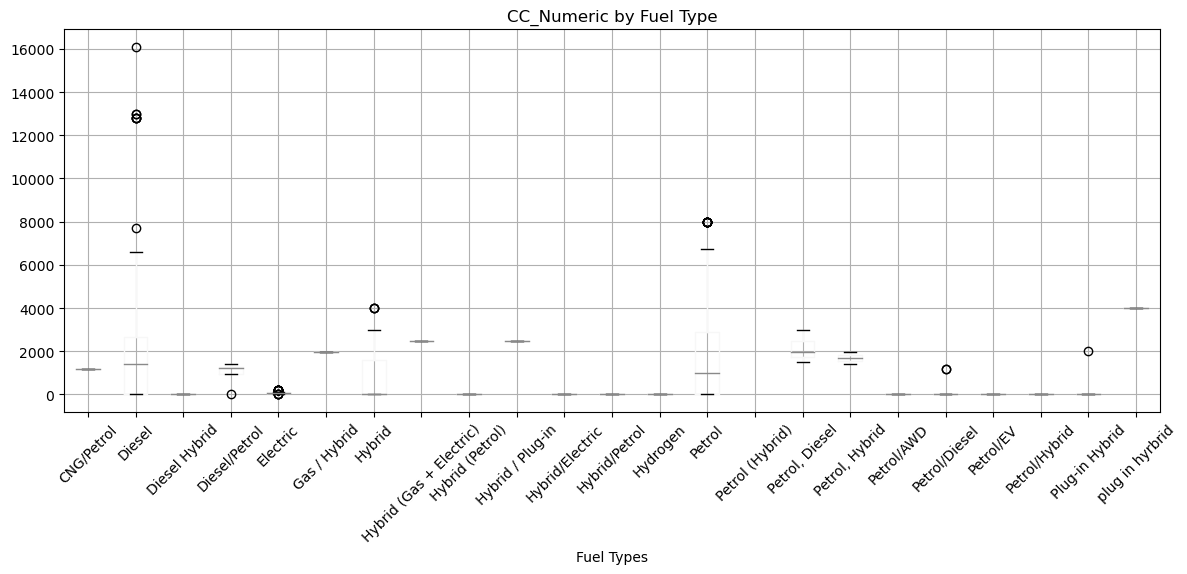


--- HP_Numeric by Fuel Type ---
                         count        mean  median         std
Fuel Types                                                    
CNG/Petrol                   1   86.000000    86.0         NaN
Diesel                     106  223.905660   163.0  257.315649
Diesel Hybrid                1  150.000000   150.0         NaN
Diesel/Petrol                4  106.000000    75.0   65.375837
Electric                    97  338.762887   320.0  215.925565
Gas / Hybrid                 1  169.000000   169.0         NaN
Hybrid                      79  317.810127   240.0  197.837286
Hybrid (Gas + Electric)      1  240.000000   240.0         NaN
Hybrid (Petrol)              4  567.500000   562.5  130.160158
Hybrid / Plug-in             1  219.000000   219.0         NaN
Hybrid/Electric              1  139.000000   139.0         NaN
Hybrid/Petrol                1  191.000000   191.0         NaN
Hydrogen                     3  154.666667   152.0    5.507571
Petrol                

<Figure size 1000x600 with 0 Axes>

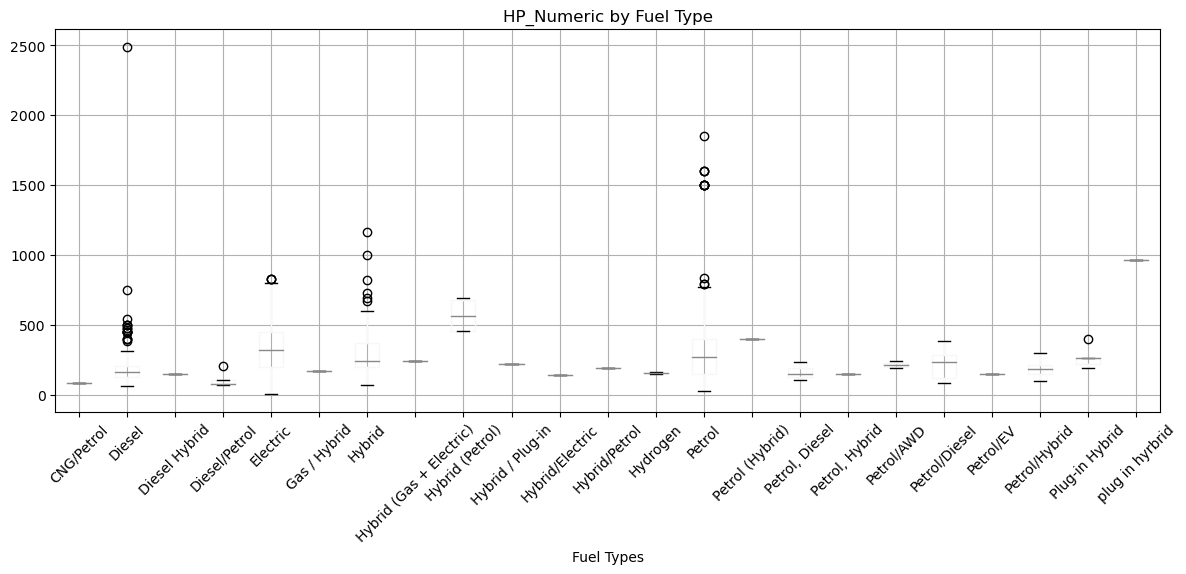


--- TopSpeed_Numeric by Fuel Type ---
                         count        mean  median        std
Fuel Types                                                   
CNG/Petrol                   1  165.000000   165.0        NaN
Diesel                     106  169.216981   175.0  31.892380
Diesel Hybrid                1  120.000000   120.0        NaN
Diesel/Petrol                4  162.500000   162.5  10.408330
Electric                    97  191.721649   190.0  48.314668
Gas / Hybrid                 1  190.000000   190.0        NaN
Hybrid                      79  221.291139   200.0  51.014114
Hybrid (Gas + Electric)      1  180.000000   180.0        NaN
Hybrid (Petrol)              4  292.500000   287.5  16.583124
Hybrid / Plug-in             1  200.000000   200.0        NaN
Hybrid/Electric              1  160.000000   160.0        NaN
Hybrid/Petrol                1  180.000000   180.0        NaN
Hydrogen                     3  180.000000   180.0   0.000000
Petrol                     871 

<Figure size 1000x600 with 0 Axes>

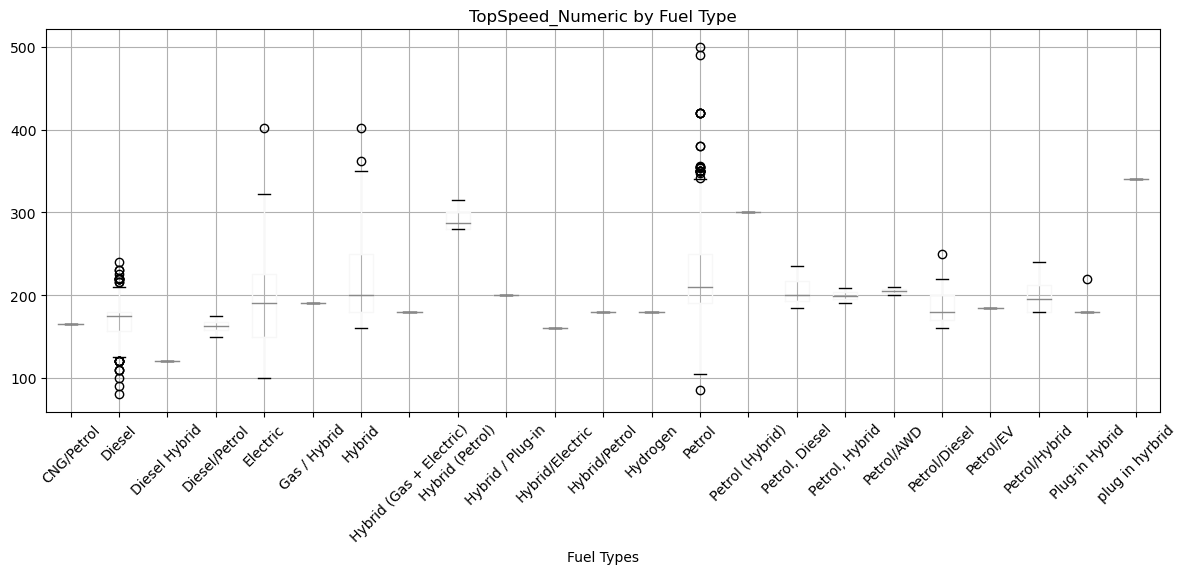


--- Acceleration_Numeric by Fuel Type ---
                         count       mean  median       std
Fuel Types                                                 
CNG/Petrol                   1  12.000000   12.00       NaN
Diesel                     103  11.486408   11.00  3.165068
Diesel Hybrid                0        NaN     NaN       NaN
Diesel/Petrol                4  14.125000   14.50  2.719528
Electric                    96   5.885417    5.15  2.564370
Gas / Hybrid                 1   8.000000    8.00       NaN
Hybrid                      79   6.962025    7.50  2.400123
Hybrid (Gas + Electric)      1   7.600000    7.60       NaN
Hybrid (Petrol)              4   3.900000    4.00  0.600000
Hybrid / Plug-in             1   6.000000    6.00       NaN
Hybrid/Electric              1   8.500000    8.50       NaN
Hybrid/Petrol                1   6.500000    6.50       NaN
Hydrogen                     3   8.666667    9.00  0.757188
Petrol                     871   7.278071    6.90  3.1600

<Figure size 1000x600 with 0 Axes>

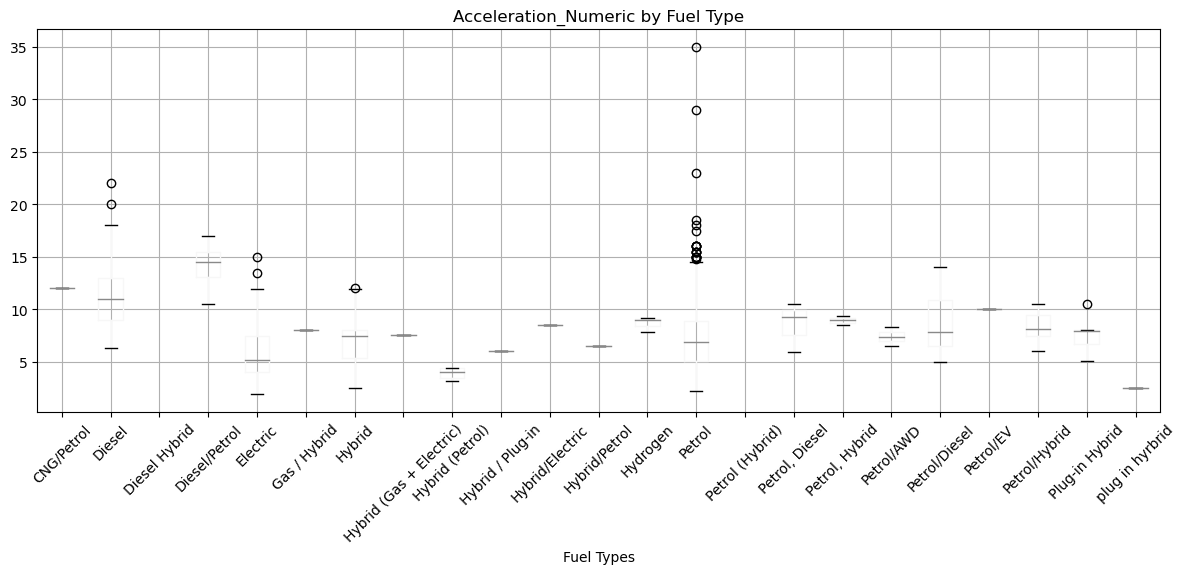


--- Price_Numeric by Fuel Type ---
                         count        mean  median         std
Fuel Types                                                    
CNG/Petrol                   1   11.000000    11.0         NaN
Diesel                     106   41.905660    35.0   26.536777
Diesel Hybrid                1   50.000000    50.0         NaN
Diesel/Petrol                4   20.000000     8.5   23.338095
Electric                    97   67.618557    59.0   38.185524
Gas / Hybrid                 1   25.000000    25.0         NaN
Hybrid                      79   64.556962    45.0   74.883970
Hybrid (Gas + Electric)      1   43.000000    43.0         NaN
Hybrid (Petrol)              4  148.750000   145.0   37.052890
Hybrid / Plug-in             1   29.000000    29.0         NaN
Hybrid/Electric              1   18.000000    18.0         NaN
Hybrid/Petrol                1   22.000000    22.0         NaN
Hydrogen                     3   46.333333    49.0    7.371115
Petrol             

<Figure size 1000x600 with 0 Axes>

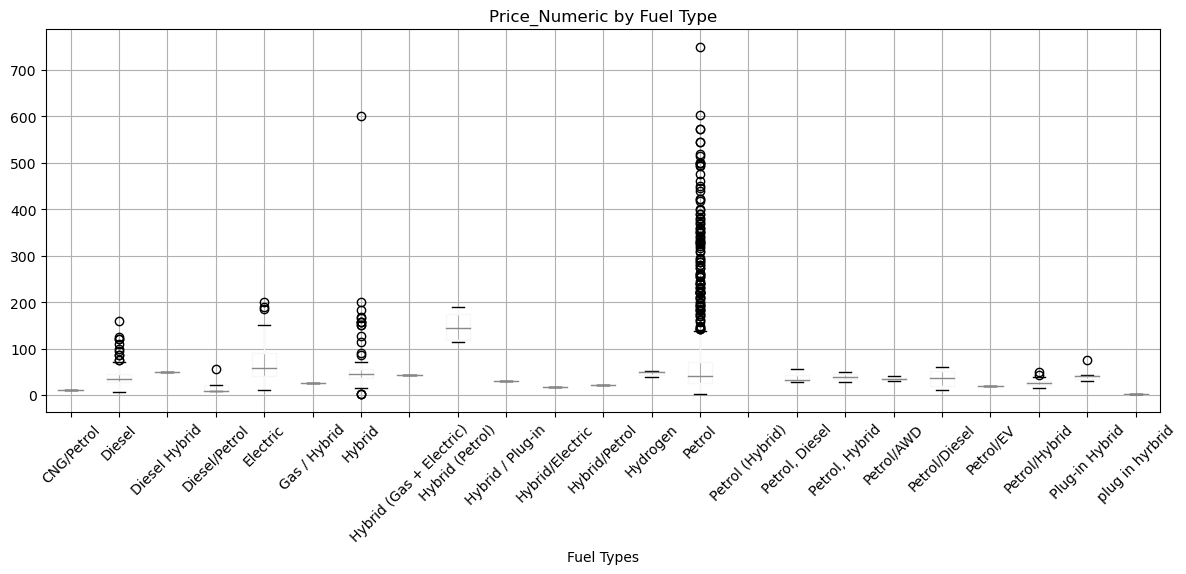


--- Seats_Numeric by Fuel Type ---
                         count      mean  median       std
Fuel Types                                                
CNG/Petrol                   1  5.000000     5.0       NaN
Diesel                     106  5.188679     5.0  2.480834
Diesel Hybrid                1  2.000000     2.0       NaN
Diesel/Petrol                4  5.500000     5.0  1.000000
Electric                    97  4.814433     5.0  0.845699
Gas / Hybrid                 1  5.000000     5.0       NaN
Hybrid                      79  4.911392     5.0  1.388505
Hybrid (Gas + Electric)      1  5.000000     5.0       NaN
Hybrid (Petrol)              4  4.250000     4.0  0.500000
Hybrid / Plug-in             1  5.000000     5.0       NaN
Hybrid/Electric              1  5.000000     5.0       NaN
Hybrid/Petrol                1  5.000000     5.0       NaN
Hydrogen                     3  5.000000     5.0  0.000000
Petrol                     871  4.762342     5.0  1.456576
Petrol (Hybrid)     

<Figure size 1000x600 with 0 Axes>

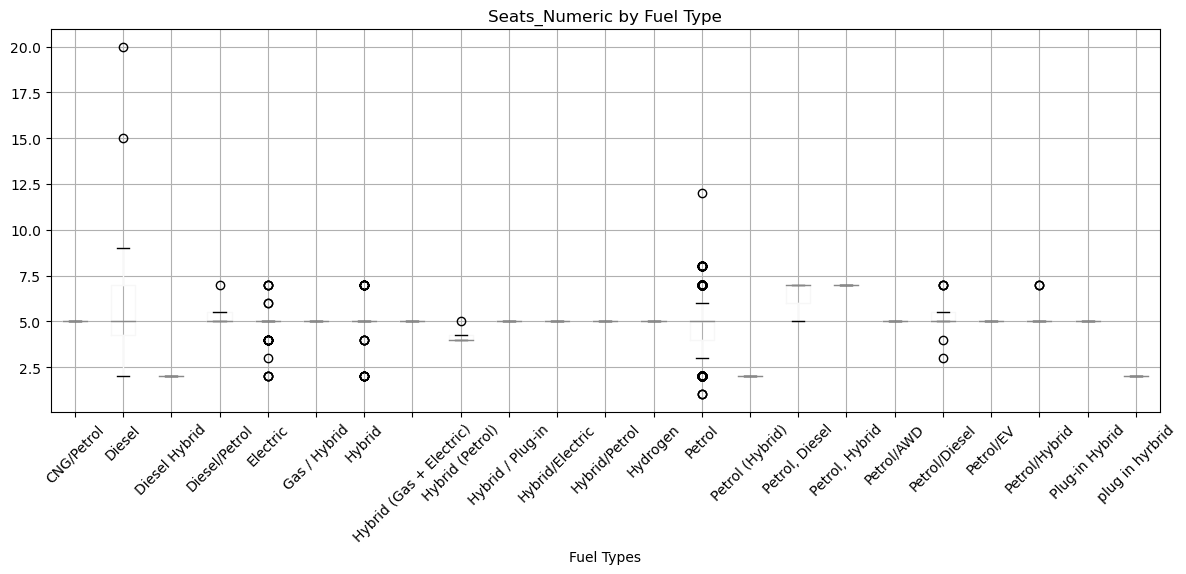


--- Torque_Numeric by Fuel Type ---
                         count        mean  median         std
Fuel Types                                                    
CNG/Petrol                   1  113.000000   113.0         NaN
Diesel                     106  548.103774   380.0  586.113542
Diesel Hybrid                1  370.000000   370.0         NaN
Diesel/Petrol                4  256.250000   195.0  164.993687
Electric                    97  440.340206   360.0  271.737959
Gas / Hybrid                 1  190.000000   190.0         NaN
Hybrid                      79  443.455696   360.0  210.785089
Hybrid (Gas + Electric)      1  239.000000   239.0         NaN
Hybrid (Petrol)              4  792.500000   785.0  107.509689
Hybrid / Plug-in             1  221.000000   221.0         NaN
Hybrid/Electric              1  295.000000   295.0         NaN
Hybrid/Petrol                1  250.000000   250.0         NaN
Hydrogen                     3  356.666667   335.0   37.527767
Petrol            

<Figure size 1000x600 with 0 Axes>

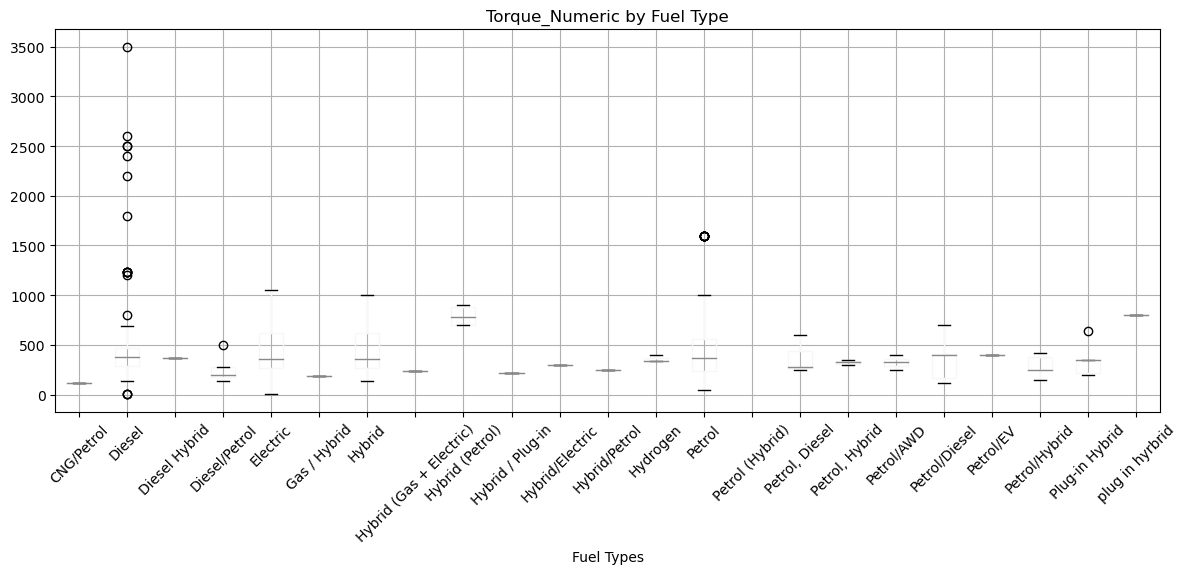


ANALYSIS BY COMPANY (TOP 10)
Top 10 companies by number of models:
Nissan        149
Volkswagen    109
Porsche        96
Mazda          87
Mitsubishi     60
GMC            59
Chevrolet      58
Peugeot        54
Kia            54
Ford           54
Name: Company Names, dtype: int64

--- CC_Numeric by Company (Top 10) ---
               count         mean  median          std
Company Names                                         
Chevrolet         58  3775.241379  3600.0  2100.899852
Nissan           148  2694.378378  2393.0  1445.257393
Porsche           96  2644.331250  2981.0  1364.552425
Kia               54  2017.118519  1591.0  1052.852515
Volkswagen       109  1559.379817  1598.0   832.986896
GMC               59  1409.491525     6.0  2292.029852
Mitsubishi        60    57.266667     2.0   183.284337
Mazda             86    44.401163     2.0   158.361441
Ford              54     7.259259     2.0    19.326573
Peugeot           52     3.865385     1.0    11.528360


<Figure size 1400x600 with 0 Axes>

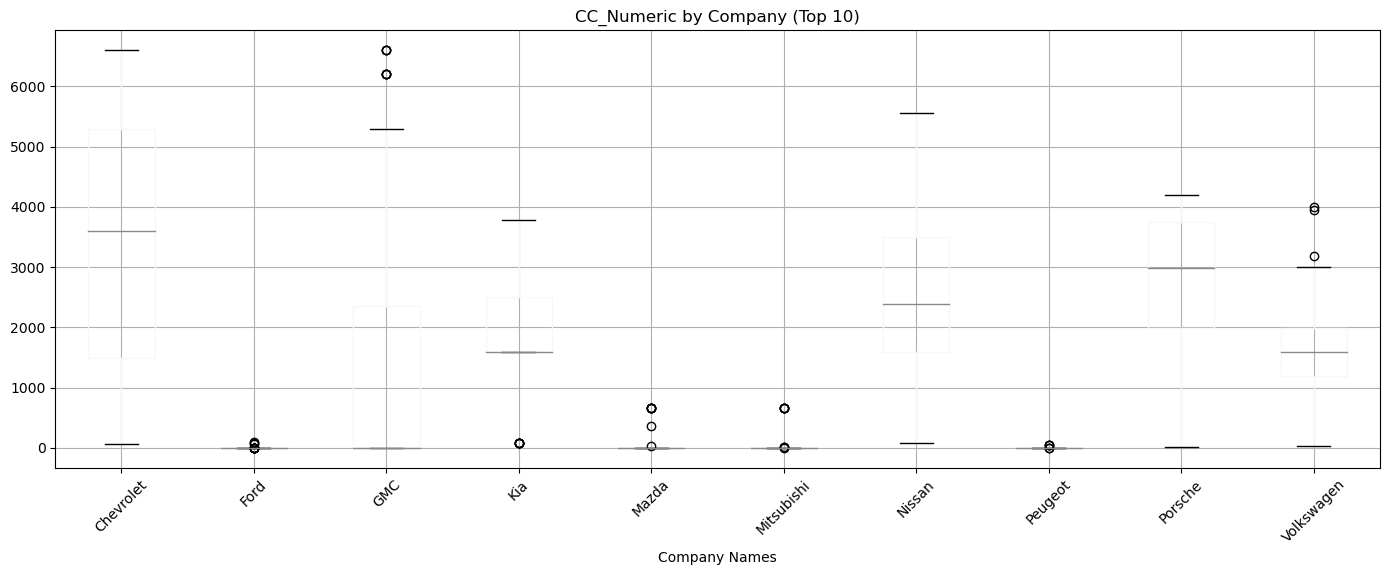


--- HP_Numeric by Company (Top 10) ---
               count        mean  median         std
Company Names                                       
Porsche           96  463.260417   454.0  122.842325
GMC               59  364.677966   355.0  165.575844
Chevrolet         58  303.672414   310.0  117.959313
Ford              54  300.759259   283.5  149.343713
Nissan           149  257.328859   201.0  228.464511
Kia               54  219.074074   201.0   85.680594
Peugeot           54  180.129630   152.5   78.337212
Volkswagen       109  168.944954   150.0   73.889537
Mazda             87  157.505747   138.0   87.808310
Mitsubishi        60  146.433333   149.0   52.699135


<Figure size 1400x600 with 0 Axes>

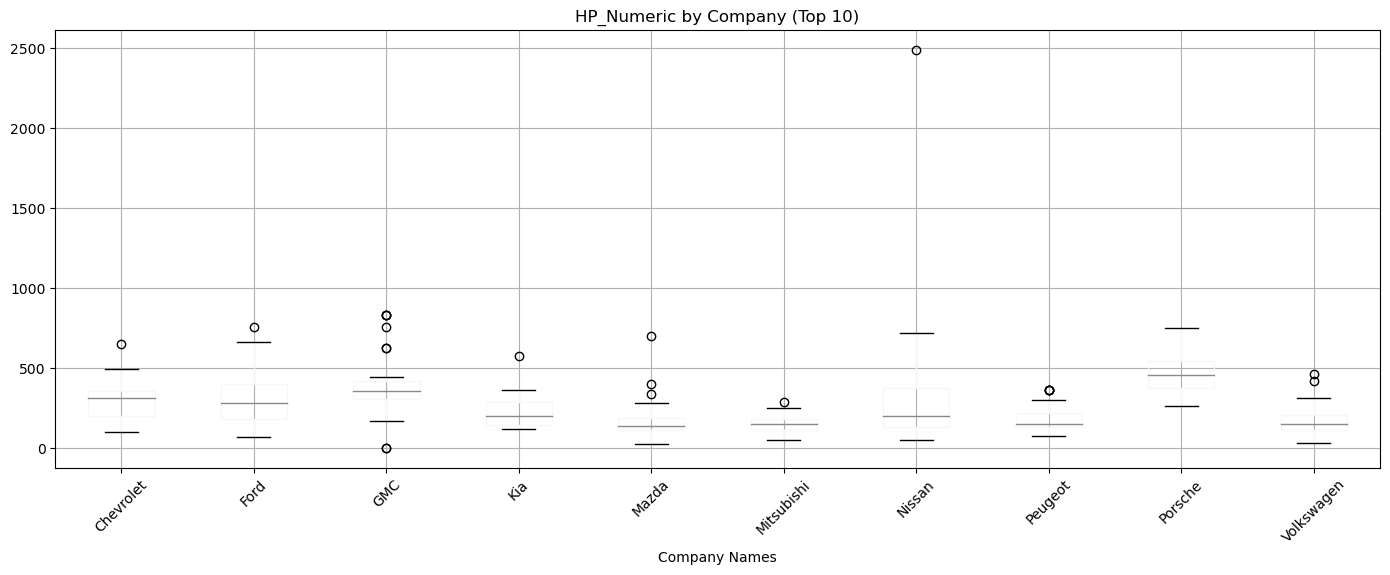


--- TopSpeed_Numeric by Company (Top 10) ---
               count        mean  median        std
Company Names                                      
Porsche           96  278.468750   280.0  29.759723
Kia               54  209.444444   200.0  25.433351
Volkswagen       109  203.587156   205.0  32.773977
Peugeot           54  202.129630   200.0  31.105448
Nissan           149  200.281879   195.0  41.302948
Chevrolet         58  200.206897   195.0  38.822474
Ford              54  198.592593   190.0  37.024479
GMC               59  188.559322   190.0  15.370450
Mazda             87  185.045977   185.0  38.145349
Mitsubishi        60  174.466667   180.0  26.004867


<Figure size 1400x600 with 0 Axes>

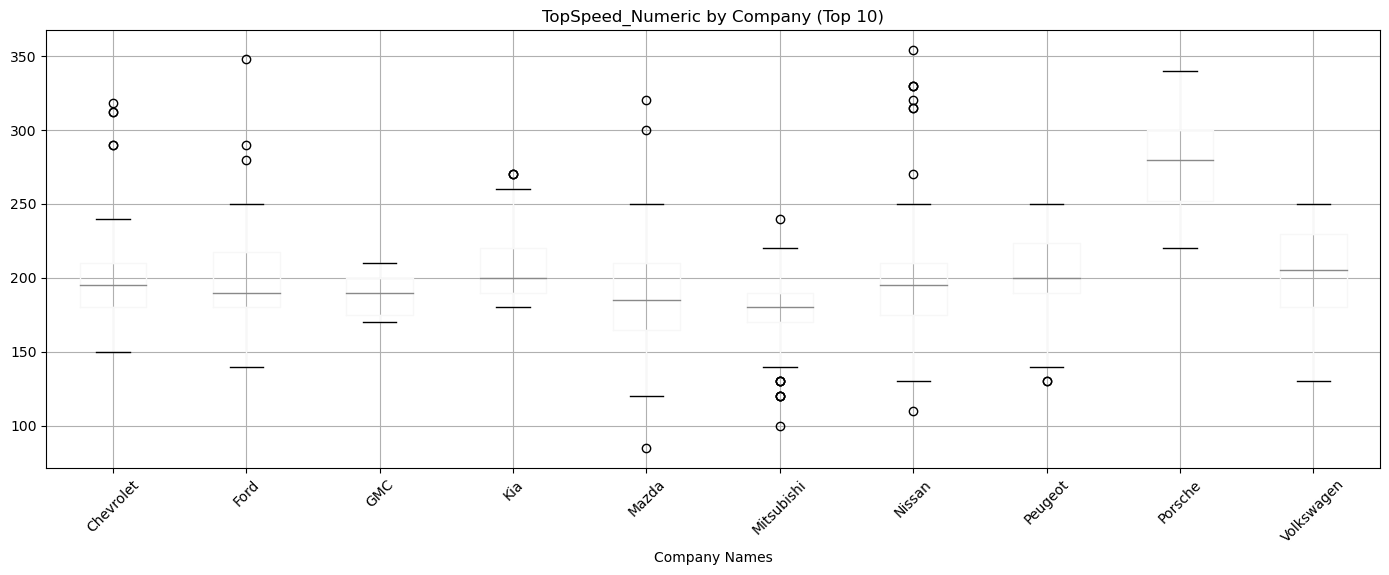


--- Acceleration_Numeric by Company (Top 10) ---
               count       mean  median       std
Company Names                                    
Mitsubishi        56  11.001786   10.50  1.885976
Mazda             86  10.419767    9.50  3.914793
Nissan           149   8.706040    8.20  3.187523
Peugeot           54   8.609259    8.50  2.110465
Volkswagen       109   8.539450    8.00  2.760972
Kia               54   7.859259    7.90  1.819757
Chevrolet         58   7.303448    7.10  1.693638
Ford              54   7.274074    6.75  2.328104
GMC               59   6.854237    7.30  1.639315
Porsche           96   4.254167    4.15  1.033432


<Figure size 1400x600 with 0 Axes>

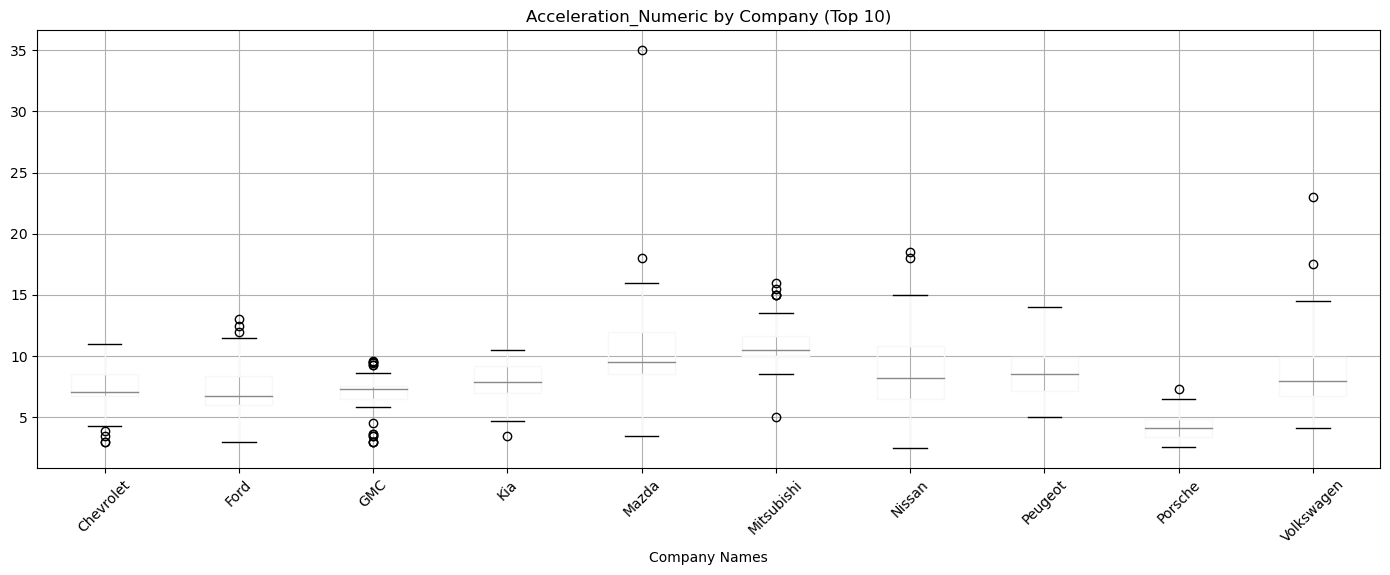


--- Price_Numeric by Company (Top 10) ---
               count        mean  median        std
Company Names                                      
Porsche           96  138.135417   113.0  83.980527
GMC               59   63.000000    60.0  23.575996
Ford              54   49.870370    39.0  64.809167
Nissan           149   46.342282    35.0  56.891525
Chevrolet         58   44.413793    43.0  17.956120
Kia               54   36.592593    34.5  13.555641
Volkswagen       109   36.256881    32.0  17.614916
Peugeot           54   35.388889    35.0   9.562933
Mitsubishi        60   26.533333    25.0  11.148408
Mazda             86   21.779070    20.0   9.154107


<Figure size 1400x600 with 0 Axes>

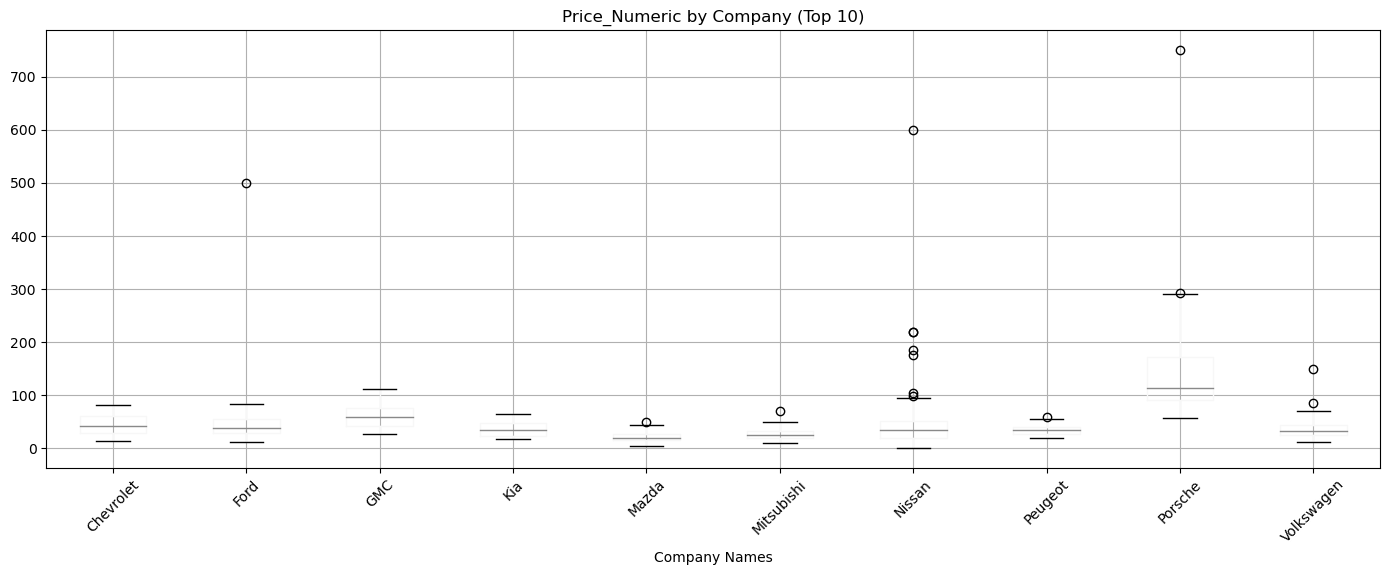


--- Seats_Numeric by Company (Top 10) ---
               count      mean  median       std
Company Names                                   
GMC               59  5.779661     5.0  1.352747
Kia               54  5.722222     5.0  1.106016
Chevrolet         58  5.655172     5.0  1.408642
Mitsubishi        60  5.350000     5.0  1.400061
Peugeot           54  5.111111     5.0  0.904218
Nissan           149  5.046980     5.0  1.768094
Volkswagen       109  4.926606     5.0  1.060280
Ford              54  4.666667     5.0  1.613621
Mazda             87  4.413793     5.0  1.418743
Porsche           96  3.854167     4.0  1.015451


<Figure size 1400x600 with 0 Axes>

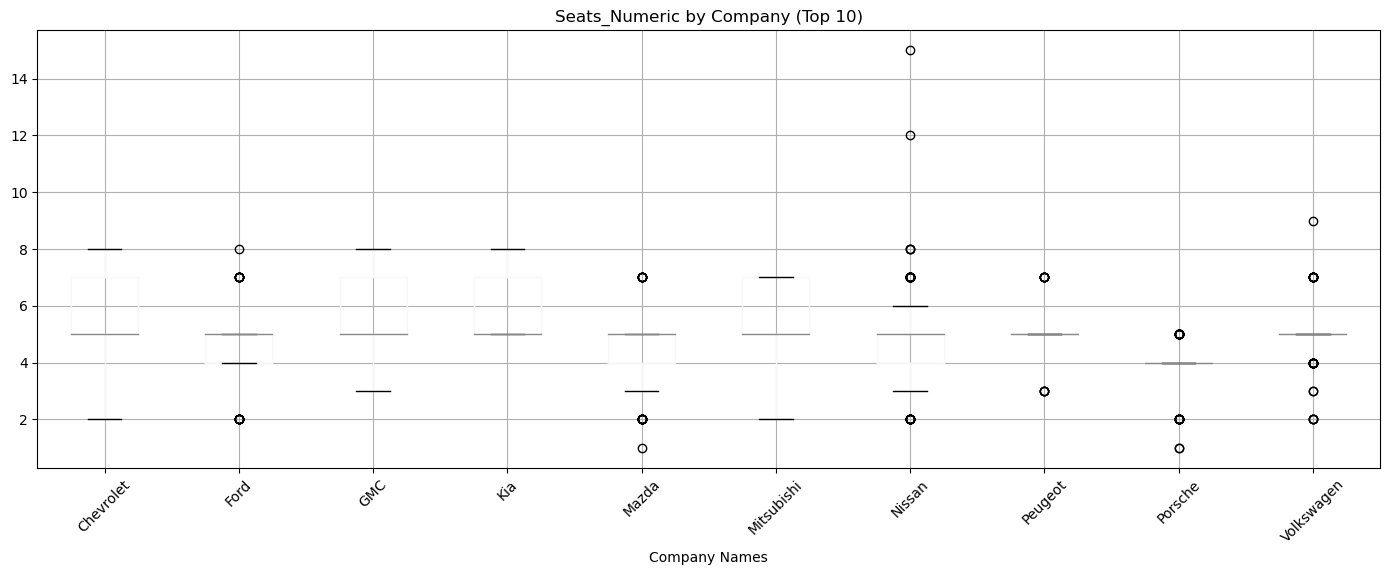


--- Torque_Numeric by Company (Top 10) ---
               count        mean  median         std
Company Names                                       
Porsche           96  582.333333   550.0  166.511493
GMC               59  485.406780   519.0  258.778105
Chevrolet         58  473.172414   456.5  237.178602
Ford              54  415.000000   405.0  232.813959
Nissan           149  334.771812   305.0  162.694961
Volkswagen       109  308.018349   310.0  117.538802
Peugeot           54  301.111111   260.0  100.820533
Kia               54  300.351852   265.0  111.135844
Mitsubishi        60  251.416667   212.0  132.805617
Mazda             86  211.953488   188.5   99.844338


<Figure size 1400x600 with 0 Axes>

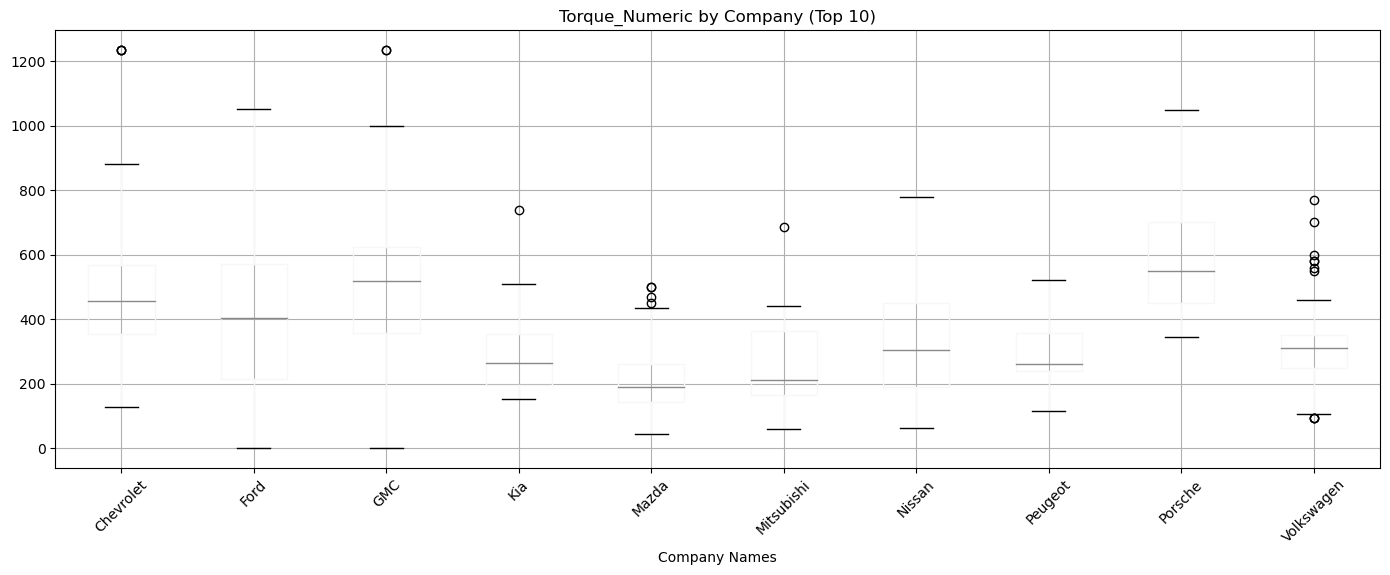


OUTLIER DETECTION

--- CC_Numeric ---
Q1: 2.00, Q3: 2000.00, IQR: 1998.00
Lower bound: -2995.00, Upper bound: 4997.00
Number of outliers: 92 (7.6%)

--- HP_Numeric ---
Q1: 150.00, Q3: 400.00, IQR: 250.00
Lower bound: -225.00, Upper bound: 775.00
Number of outliers: 22 (1.8%)

--- TopSpeed_Numeric ---
Q1: 180.00, Q3: 250.00, IQR: 70.00
Lower bound: 75.00, Upper bound: 355.00
Number of outliers: 13 (1.1%)

--- Acceleration_Numeric ---
Q1: 5.20, Q3: 9.50, IQR: 4.30
Lower bound: -1.25, Upper bound: 15.95
Number of outliers: 23 (1.9%)

--- Price_Numeric ---
Q1: 26.00, Q3: 68.00, IQR: 42.00
Lower bound: -37.00, Upper bound: 131.00
Number of outliers: 129 (10.6%)

--- Seats_Numeric ---
Q1: 4.00, Q3: 5.00, IQR: 1.00
Lower bound: 2.50, Upper bound: 6.50
Number of outliers: 331 (27.2%)

--- Torque_Numeric ---
Q1: 250.00, Q3: 560.00, IQR: 310.00
Lower bound: -215.00, Upper bound: 1025.00
Number of outliers: 26 (2.1%)

EDA ANALYSIS COMPLETE!

Analysis completed successfully!
Cleaned dataset shape

In [3]:
# Usage example:
if __name__ == "__main__":
    # Replace 'Cars Datasets 2025.csv' with your actual file path
    filepath = 'Cars Datasets 2025.csv'
    
    try:
        df_analyzed = main_analysis(filepath)
        print("\nAnalysis completed successfully!")
        print(f"Cleaned dataset shape: {df_analyzed.shape}")
        
    except FileNotFoundError:
        print(f"Error: Could not find the file '{filepath}'")
        print("Please make sure the file exists in the current directory or provide the correct path.")
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your data file and try again.")